In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def tokenize(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))
            
        return tokens
        
    def encode(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1
            
        return vectors

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.tokenize(unicode_jamo_list)

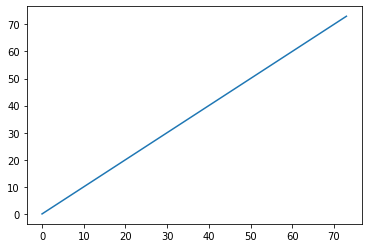

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [9]:
embedding_layer = nn.Embedding(len(jamo_tokens), 256)

In [10]:
dictionary_tensor = torch.tensor(jamo_tokens)

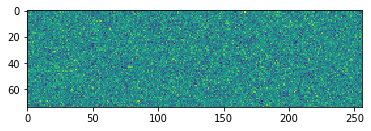

In [11]:
plt.imshow(embedding_layer(dictionary_tensor).detach().numpy())

초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
104


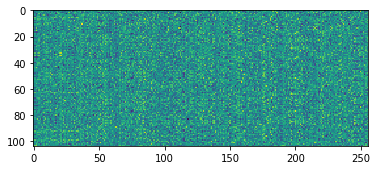

In [31]:
print(metadata[5031, 3])
print(metadata[5031, 2])
print(len(metadata[5031, 3]))

input_token = tokenizer.tokenize(metadata[5031, 3])
input_tensor = torch.tensor(input_token)
plt.imshow(embedding_layer(input_tensor).detach().numpy())

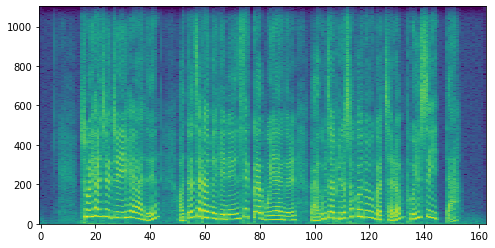

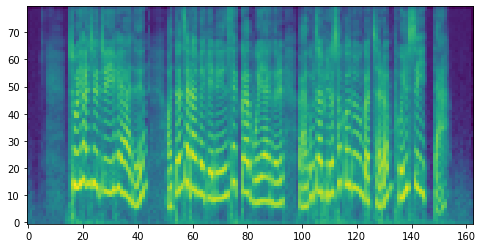

In [32]:
for i, wav_name in enumerate([wave_name_list[5031]]):
    wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
    y, sr = librosa.core.load(wav_path)
    
    f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

    Sxx = np.abs(Zxx)
    Sxx = np.maximum(Sxx, eps)

    # plt.figure(figsize=(20,20))
    # plt.imshow(20*np.log10(Sxx), origin='lower')
    # plt.colorbar()
    # plt.show()

    mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

    mel_specgram = np.matmul(mel_filters, Sxx)

    log_specgram = 20*np.log10(Sxx)

    norm_log_specgram = (log_specgram + db_ref) / db_ref

    log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

    norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
#     np.save(specgram_path, norm_log_specgram)
#     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
#     print(norm_log_mel_specgram.shape[1])

    if i % 1000 == 0:

        plt.figure(figsize=(8, 4))
        plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
#         plt.colorbar()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#         plt.colorbar()
        plt.show()    
    break

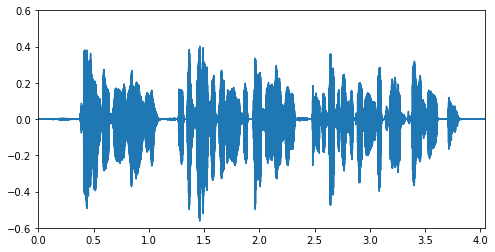

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, len(y)/fs, 1/fs), y)
plt.ylim([-.6, .6])
plt.xlim([0, len(y)/fs])
plt.show()

In [71]:
input_spectrogram = norm_log_mel_specgram.T
print(input_spectrogram.shape)

(163, 80)


In [222]:
class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(query + key)
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose_(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector

class Mel2SeqNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True)
        self.attention = AttentionModule(D_out * 2)
        self.fc_s = nn.Linear(1024, 512)
        self.fc_pred = nn.Linear(512, 74)
        self.final_softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, ground_truth):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        encoded_tensor, _ = self.gru(output_tensor)
        output_tensor = self.fc_2(encoded_tensor)
        output_tensor = self.relu_2(output_tensor)
        hidden = encoded_tensor[:, -1, :].view(1, 1, self.H)
        
        pred_tensor_list = list()
        
        for i in range(len(ground_truth)):
            context_vector = self.attention(encoded_tensor, hidden)
            s = torch.cat([encoded_tensor[:, i, :].view(encoded_tensor.shape[0], 1, encoded_tensor.shape[2]), context_vector], dim=2)
            hidden = self.fc_s(s)
            output_tensor = self.fc_pred(hidden)
            prediction = self.final_softmax(output_tensor)
            pred_tensor_list.append(prediction)
            
        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        
        
        return pred_tensor
    
encoding_layer = Mel2SeqNet(80, 512, 256)

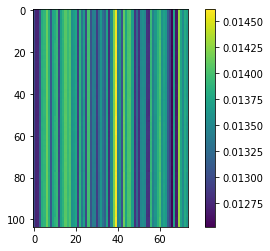

In [229]:
tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
encoded = encoding_layer(tensor_input, metadata[5031, 3])
plt.imshow(encoded.detach().numpy()[0])
plt.colorbar()
plt.show()

In [178]:
torch.cat([torch.tensor([[1, 2, 3], [1, 2, 3]]), torch.tensor([[1, 2, 3], [1, 2, 3]])], 1).shape

torch.Size([2, 6])